# ***Imports***

In [1]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import tensorflow_addons as tfa

In [2]:
import tensorflow as tf
from tensorflow.keras import layers,Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# ***Parameters***

In [3]:
LOCAL_MACHINE = False
SHAPE = (224,224)
BATCH_SIZE = 32
SEED = 42
train_path = "/kaggle/input/image-depth-estimation/data/nyu2_train"

# ***Dataset***

In [ ]:
def preprocess(file_type) : 
    def preprocess_image(file_path):
        # Read the image file
        image = tf.io.read_file(file_path)
        # Decode the image to a tensor
        image = tf.image.decode_jpeg(image, channels=1) if file_type else tf.image.decode_png(image, channels=1)
        # Resize the image
        image = tf.image.resize(image, SHAPE)  
        # Normalize the image
        image = image / 255.0  
        return image
    return preprocess_image

In [4]:
images_path = tf.data.Dataset.list_files(train_path + '/*/*.jpg',seed=SEED) # images in colors
targets_path = tf.data.Dataset.list_files(train_path + '/*/*.png',seed=SEED)  # images with depth estimation
# if True it means decode as JPG else PNG
images = images_path.map(preprocess(True)) 
targets = targets_path.map(preprocess(False))

In [5]:
FACTEUR = 0.3
MAX_DATA = int(len(images)*FACTEUR)

images = images.take(MAX_DATA)
targets = targets.take(MAX_DATA)

images = images.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
targets = targets.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ***Showing data***

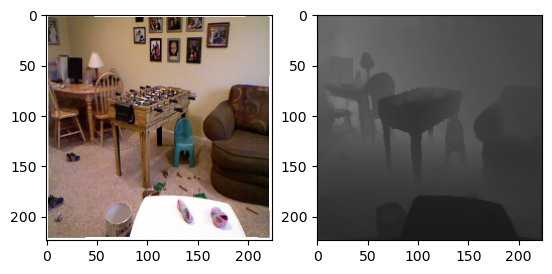

In [6]:
_,real_im = next(enumerate(images))
_,target_im = next(enumerate(targets))

nb = random.randint(0,BATCH_SIZE-1)

plt.figure()
plt.subplot(121)
plt.imshow(real_im[0])
plt.subplot(122)
plt.imshow(target_im[0])
plt.show()

# ***Spliting Data***

In [7]:
def get_train(data,train_count):
    return data.take(train_count)

def get_validation(data,train_count):
    return data.skip(train_count)

In [8]:
VALID = False
if VALID : 
    train_size = 0.8 
    train_count = int(len(images) * train_size)  # Number of train samples

    X_train = get_train(images,train_count)
    y_train = get_train(targets,train_count)

    X_test = get_validation(images,train_count)
    y_test = get_validation(targets,train_count)
else:
    X_train = images
    y_train = targets

# ***Model***

In [9]:
class EncoderBlock(layers.Layer):
    def __init__(self,filters):
        super(EncoderBlock,self).__init__()
        
        self.conv_1 = layers.Conv2D(filters=filters,kernel_size=(3,3),strides=(1,1),padding="same")
        self.conv_2 = layers.Conv2D(filters=filters,kernel_size=(3,3),strides=(1,1),padding="same")
        
        self.bn_1 = layers.BatchNormalization()
        self.bn_2 = layers.BatchNormalization()
        
        self.downsampling = layers.MaxPool2D(pool_size=(2,2)) 
    
        self.relu = layers.ReLU()
        
    def call(self,X):
        X = self.conv_1(X)
        X = self.bn_1(X)
        X = self.relu(X)
        
        X = self.conv_2(X)
        X = self.bn_2(X)
        X = self.relu(X)
        
        return self.downsampling(X)

class DecoderBlock(layers.Layer) : 
    def __init__(self,filters,use_pool=True):
        super(DecoderBlock,self).__init__()
        
        self.conv_1 = layers.Conv2D(filters=filters,kernel_size=(3,3),strides=(1,1),padding="same")
        self.conv_2 = layers.Conv2D(filters=filters,kernel_size=(3,3),strides=(1,1),padding="same")
        
        self.bn_1 = layers.BatchNormalization()
        self.bn_2 = layers.BatchNormalization()

        self.relu = layers.ReLU()
        self.upsampling = layers.UpSampling2D(size=(2,2)) if use_pool else layers.Conv2DTranspose(
            filters=filters,
            kernel_size=(4,4),
            strides=(2,2),
            padding="same"
        )
        
    def call(self,X):
        X = self.conv_1(X)
        X = self.bn_1(X)
        X = self.relu(X)
        
        X = self.conv_2(X)
        X = self.bn_2(X)
        X = self.relu(X)
        
        return self.upsampling(X)

class DepthModel(Model):
    def __init__(self,image_dim=3):
        super(DepthModel,self).__init__()
        self.first_conv = layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding="same")
        self.encoder = [
            EncoderBlock(128),       
            EncoderBlock(256),  
            EncoderBlock(512),  
            EncoderBlock(1024),  
        ]
        self.decoder = [
            DecoderBlock(512,False),       
            DecoderBlock(256,False),  
            DecoderBlock(128,False),  
            DecoderBlock(64,False),  
        ]
        self.last_conv = layers.Conv2D(filters=image_dim,kernel_size=(1,1),strides=(1,1))

    def call(self,X):
        encoder_output = []
        X = self.first_conv(X)
        # ----------------------------- Encoder
        for encoder in self.encoder:
            X = encoder(X)
            encoder_output.append(X)
        # ----------------------------- Decoder
        for decoder in self.decoder:
            residual_connexion = encoder_output.pop()
            X = tf.concat([X, residual_connexion], axis=-1)
            X = decoder(X)

        return self.last_conv(X)

In [10]:
LR = 1e-4
image_dim = real_im[nb].shape[-1]
model = DepthModel(image_dim=image_dim)
opt = Adam(learning_rate=LR)

# ***Functions***

In [11]:
@tf.function
def train_step(X,target):    
    with tf.GradientTape() as tape:
        prediction = model(X)
        loss = get_loss(prediction,target)
    gradients = tape.gradient(loss,model.trainable_variables)
    opt.apply_gradients(zip(gradients,model.trainable_variables))
    return loss

@tf.function
def val_step(X,target):
    prediction = model(X)
    loss = get_loss(prediction,target)
    return loss

# Get this from Keras docs
@tf.function
def get_loss(pred,target):
    ssim_loss_weight = 0.85
    l1_loss_weight = 0.1
    edge_loss_weight = 0.9
        
    # Compare edges
    target_gaussian = tfa.image.gaussian_filter2d(target)
    pred_gaussian = tfa.image.gaussian_filter2d(pred)

    dy_true, dx_true = tf.image.image_gradients(target_gaussian)
    dy_pred, dx_pred = tf.image.image_gradients(pred_gaussian)

    weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
    weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

    # Depth smoothness
    smoothness_x = dx_pred * weights_x
    smoothness_y = dy_pred * weights_y
    
    depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
        abs(smoothness_y)
    )

    # Structural similarity (SSIM) Luminance/Contrast/Structural information better than MSE
    ssim_loss = tf.reduce_mean(
        1
        - tf.image.ssim(
            target, pred, max_val=SHAPE[0], filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
        )
    )
    # MAE
    l1_loss = tf.reduce_mean(tf.abs(target - pred))

    loss = (
        (ssim_loss_weight * ssim_loss)
        + (l1_loss_weight * l1_loss)
        + (edge_loss_weight * depth_smoothness_loss)
    )

    return loss

# ***Training and Validation***

In [12]:
EPOCHS = 20
show = True
training_loss = []
val_loss = []

print("[START]")
for epoch in tf.range(EPOCHS):
    batch_loss = []
    val_batch_loss = []
    
    print(f"epoch  : {epoch+1}/{EPOCHS}")
    pb_i = Progbar(len(X_train), stateful_metrics=('loss','val_loss'))
    for batch_x,batch_y in zip(X_train,y_train):
        loss = train_step(batch_x,batch_y)        
        values=[('loss',loss)]
        pb_i.add(1, values=values)
        batch_loss.append(loss)

    if show:
        print(model.summary())
        show = False
    
    if VALID : 
        for batch_x,batch_y in zip(X_test,y_test):
            loss = val_step(batch_x,batch_y)        
            val_batch_loss.append(loss)
        values=[('val_loss',loss)]
        pb_i.add(1, values=values)  
        val_loss.append(sum(val_batch_loss)/len(val_batch_loss))
        
        
    training_loss.append(sum(batch_loss)/len(batch_loss))      
    
print("\n[END]")


[START]
epoch  : 1/20
476/476 [==============================] - 458s 871ms/step - loss: 0.0485
Model: "depth_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 encoder_block (EncoderBlock  multiple                 222464    
 )                                                               
                                                                 
 encoder_block_1 (EncoderBlo  multiple                 887296    
 ck)                                                             
                                                                 
 encoder_block_2 (EncoderBlo  multiple                 3544064   
 ck)                                                             
                                                                 
 encoder_block_3 (Encoder

In [13]:
model_path = 'depth-model'
model.save(model_path)

In [14]:
!zip -r file.zip 'depth-model'

  adding: depth-model/ (stored 0%)
  adding: depth-model/keras_metadata.pb (deflated 94%)
  adding: depth-model/variables/ (stored 0%)
  adding: depth-model/variables/variables.index (deflated 75%)
  adding: depth-model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: depth-model/saved_model.pb (deflated 91%)
  adding: depth-model/assets/ (stored 0%)
  adding: depth-model/fingerprint.pb (stored 0%)


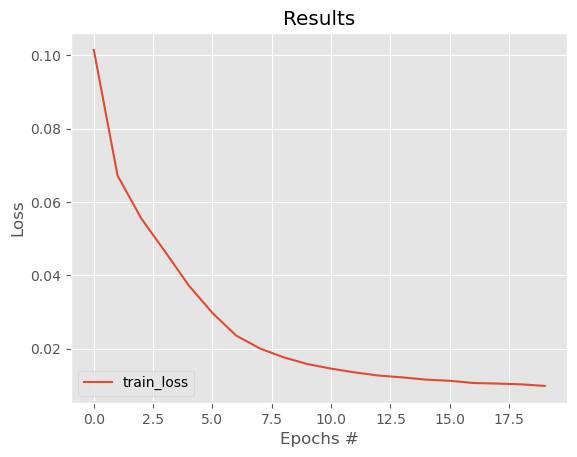

In [15]:
plt.style.use("ggplot")
plt.figure()
if VALID : 
    plt.plot(val_loss, label="val_loss")
plt.plot(training_loss, label="train_loss")
plt.title("Results")
plt.xlabel("Epochs #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot.png")
plt.show()

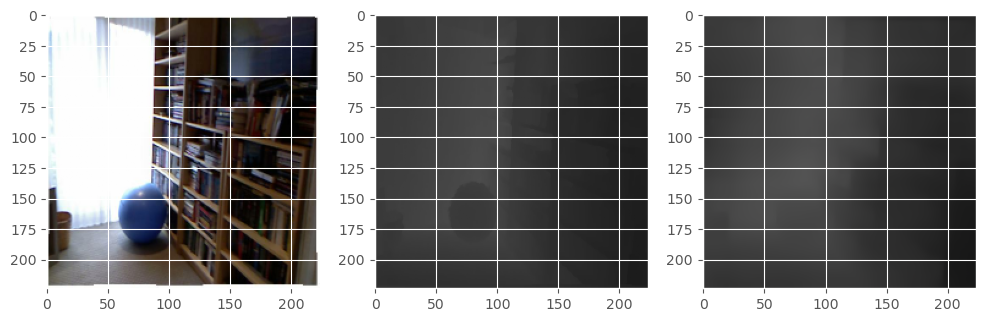

In [16]:
_,batch = next(enumerate(X_train))
_,target = next(enumerate(y_train))

image = tf.reshape(batch[0],(1,224,224,1))
prediction = model(image)
prediction = prediction[0]
prediction = np.reshape(prediction, (224, 224, 1))

plt.figure(figsize=(12,7))
plt.subplot(131)
plt.imshow(batch[0])
plt.subplot(132)
plt.imshow(target[0])
plt.subplot(133)
plt.imshow(prediction)
plt.show()

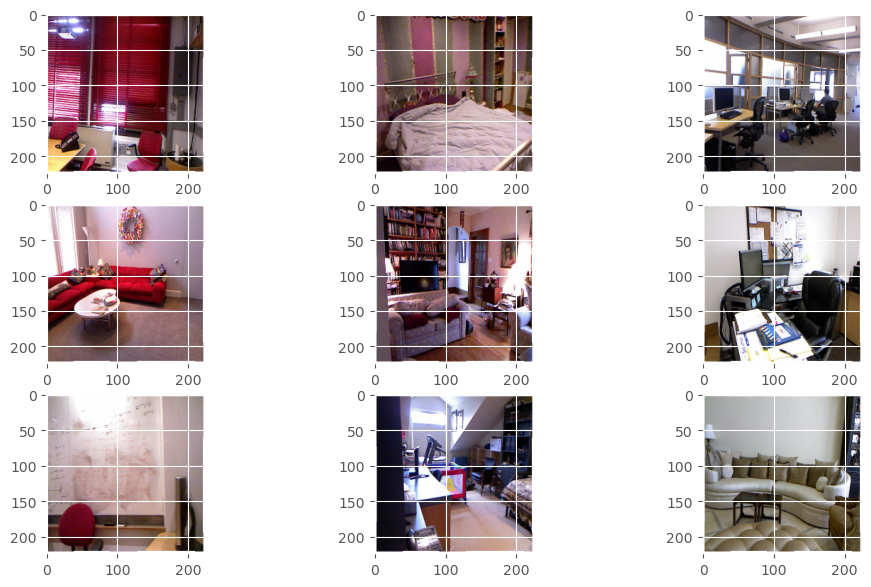

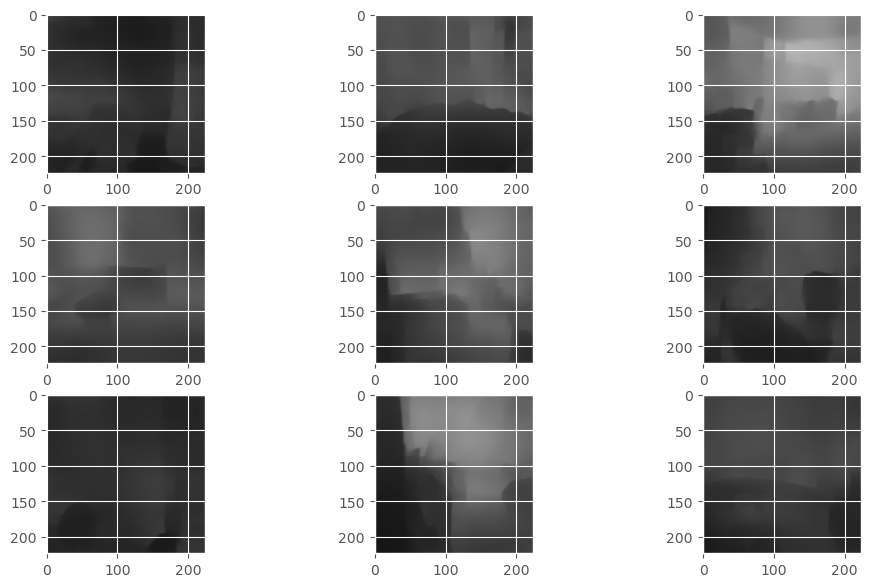

In [19]:
MAX_IMAGE = 3
model = tf.keras.models.load_model("./depth-model")

test_path = "/kaggle/input/image-depth-estimation/data/nyu2_test"

if  LOCAL_MACHINE : 
    test_path = "./test-set/*" 

test_dir = tf.data.Dataset.list_files(test_path + '/*colors.png',seed=SEED) # images in colors
test_set = test_dir.map(preprocess(False))
test_set = test_set.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

_,first_batch = next(enumerate(test_set))

prediction = model(first_batch)

plt.figure(figsize=(12,7))
for i,image in enumerate(first_batch) : 
    plt.subplot(MAX_IMAGE,MAX_IMAGE,i+1)
    plt.imshow(image)
    if (i+1) >= MAX_IMAGE**2:
        break
plt.show()

plt.figure(figsize=(12,7))
for i,image in enumerate(prediction) : 
    plt.subplot(MAX_IMAGE,MAX_IMAGE,i+1)
    plt.imshow(image)
    if (i+1) >= MAX_IMAGE**2:
        break
plt.show()